## Loan Prediction Problem Dataset

In [114]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from collections import Counter

| 欄位名（英文）           |   |
|---------------------|----------------|
| Loan_ID             | 貸款編號          |
| Gender              | 性別             |
| Married             | 婚姻狀況          |
| Dependents          | 供養人數          |
| Education           | 教育程度          |
| Self_Employed       | 自僱情況          |
| ApplicantIncome     | 申請人收入        |
| CoapplicantIncome   | 共同申請人收入     |
| LoanAmount          | 貸款金額          |
| Loan_Amount_Term    | 貸款期限          |
| Credit_History      | 信用紀錄          |
| Property_Area       | 房產區域          |
| Loan_Status         | 貸款狀態          |


In [143]:
df = pd.read_csv(r"D:\python_workspace\delta_gitlab\factor-deconstruction\loan_prediction.csv", encoding='utf-8')

## 單因子分析

In [144]:
# 加載您的貸款數據集
df = pd.read_csv('./loan_prediction.csv')  # 假設該路徑是您的貸款數據

# 處理缺失值
imputer = SimpleImputer(strategy='median')
df['LoanAmount'] = imputer.fit_transform(df[['LoanAmount']])
df['Loan_Amount_Term'] = imputer.fit_transform(df[['Loan_Amount_Term']])
df['Credit_History'] = imputer.fit_transform(df[['Credit_History']])

# Label Encoding for binary variables
label_cols = ['Gender', 'Married', 'Loan_Status', 'Self_Employed', 'Dependents', 'Education']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # 轉換為字符串處理缺失值
    label_encoders[col] = le

# One-Hot Encoding for multi-class variables
df = pd.get_dummies(df, columns=['Property_Area'])

# 將 bool 類型欄位轉換為 0/1
bool_columns = ['Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']

# 將每個布爾欄位轉換為整數
df[bool_columns] = df[bool_columns].astype(int)



In [145]:
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,1,0,0,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,1,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,1,0,0,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,1,0,0,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,1,0,0,1


In [146]:
df = df.drop('Loan_ID', axis=1)

In [147]:
# 訓練模型並獲取特徵重要性
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 獲取特徵重要性
feature_importance = rf.feature_importances_


In [148]:
# 計算相關性矩陣
correlation_matrix = df.corr()

# 顯示重要性結果
features = X.columns
importance = feature_importance * 100  # 將特徵重要性百分比化

# 將特徵和重要性進行排序
sorted_idx = np.argsort(importance)[::-1]
sorted_features = features[sorted_idx]
sorted_importance = importance[sorted_idx]


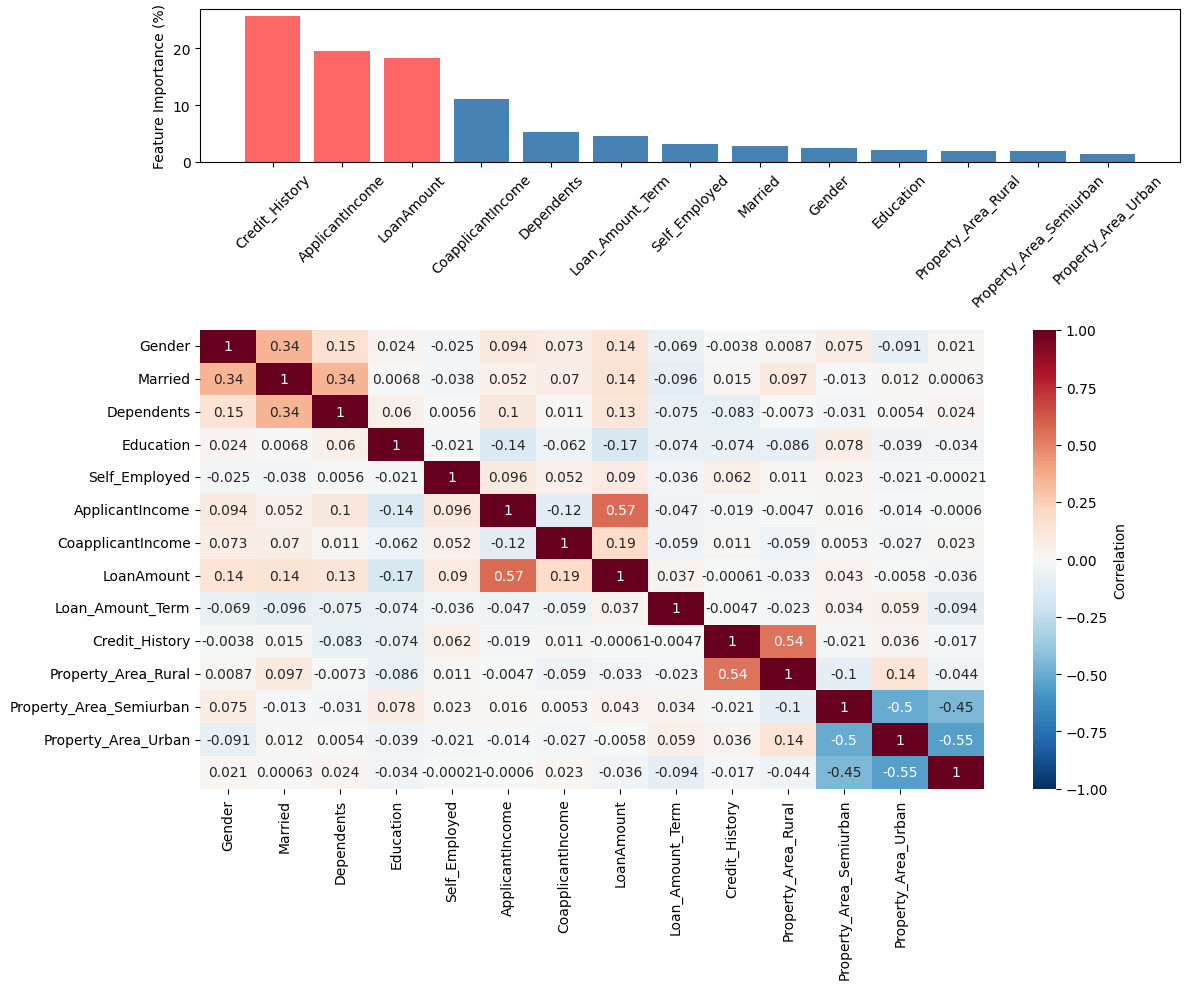

In [151]:
# 創建畫布
fig, (ax_bar, ax_heatmap) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [1, 3]}, figsize=(12, 10)
)

# 設定顏色，針對前三名特徵進行強調
colors = ['steelblue'] * len(sorted_importance)
colors[:3] = ['#ff6666', '#ff6666', '#ff6666']  # 強調前三名特徵

# 繪製解釋方差長條圖（重要性已排序），並針對前三名特徵進行顏色調整
ax_bar.bar(range(len(sorted_importance)), sorted_importance, color=colors)
ax_bar.set_ylabel("Feature Importance (%)")
ax_bar.set_xticks(range(len(sorted_features)))
ax_bar.set_xticklabels(sorted_features, rotation=45)



# 繪製相關性矩陣熱圖（對應原始順序）
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r", center=0, 
            ax=ax_heatmap, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1,
            xticklabels=features, yticklabels=features)

# 調整佈局
plt.tight_layout()
plt.show()




## 多因子分析

In [122]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.colors as mcolors

#### 確認 PCA 的主成分數量

In [131]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# 標準化數據
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用不同的 n_components 進行交叉驗證
scores = []
for n in range(1, X_scaled.shape[1] + 1):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    
    # 使用 Logistic Regression 做分類
    model = LogisticRegression(max_iter=1000)
    score = cross_val_score(model, X_pca, y, cv=10).mean()
    scores.append(score)

# 找出性能最佳的 n_components
best_n_components = np.argmax(scores) + 1

print(f"最佳的 n_components: {best_n_components}")

最佳的 n_components: 10


#### 執行 PCA

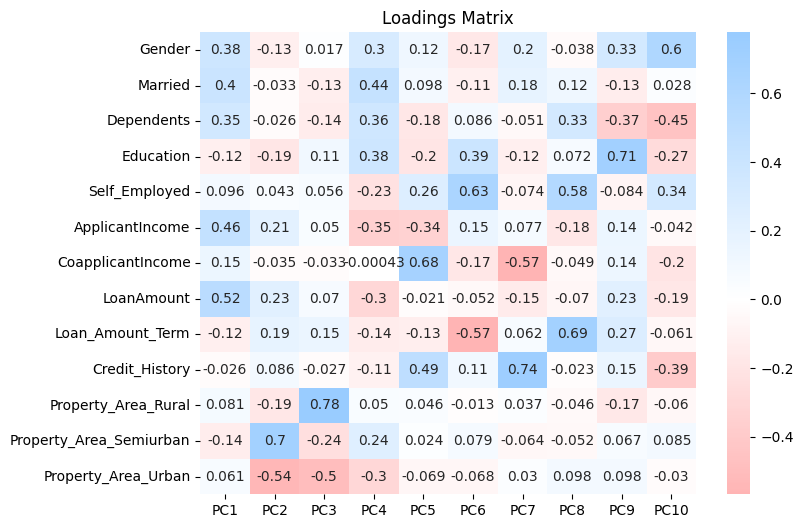

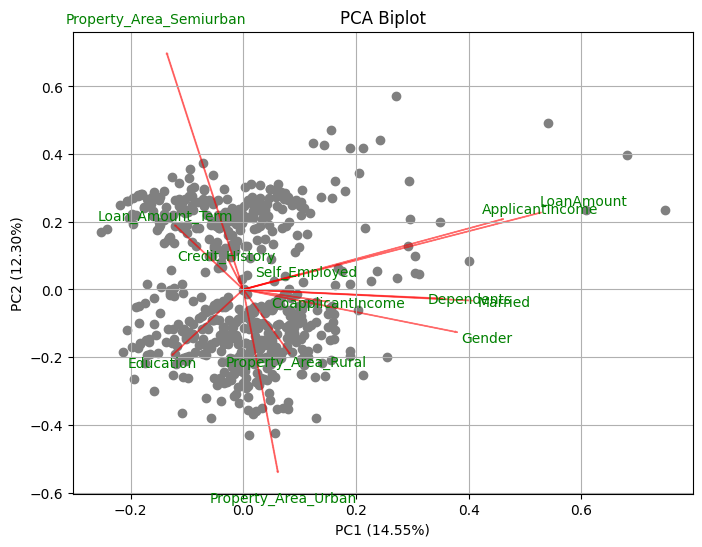

In [124]:

pca = PCA(n_components=10)
pca_data = pca.fit_transform(X_scaled)

# 獲取加載矩陣（特徵向量）
loadings = pca.components_.T
explained_variance = pca.explained_variance_ratio_

# 將加載矩陣轉換為 DataFrame 以便可視化
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(10)], index=X.columns)

# 自定義兩種色系的 colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    'two_color_cmap',
    ['#ff9999', 'white', '#99ccff'],  # 負數使用紅色調，正數使用藍色調
    N=256
)

# 繪製加載矩陣熱圖，使用自定義 cmap
plt.figure(figsize=(8, 6))
sns.heatmap(loading_df, annot=True, cmap=cmap, center=0)
plt.title("Loadings Matrix")
plt.show()

# 定義 Biplot 繪製函數
def biplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    plt.scatter(xs * scalex, ys * scaley, c='gray')
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, f"Var{i+1}", color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')

    plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}%)")
    plt.grid()

# 繪製雙圖
plt.figure(figsize=(8, 6))
biplot(pca_data, loadings[:, :2], labels=X.columns)
plt.title("PCA Biplot")
plt.show()


## 特徵降維

透過 加載矩陣 (loadings matrix) 進行 特徵縮減 是主成分分析 (PCA) 的一個常見應用，這可以幫助我們挑選對於資料變異貢獻最大的特徵，並移除冗餘或不重要的特徵。


### 根據加載矩陣進行特徵縮減的原則
- 有幾種常見的方法可以根據加載矩陣進行特徵縮減：
1. 加載值的閾值法：根據加載矩陣中的加載值設定一個閾值（絕對值的大小），保留加載值大於該閾值的特徵，將加載值較小的特徵移除，因為它們對主成分的貢獻較小。
2. 選擇前幾個主成分：可以根據解釋變異率選擇前幾個主成分，然後根據這些主成分的加載矩陣來選擇主要特徵。
3. 累積解釋變異：保留累積解釋變異率達到一定百分比（例如 90%）的主成分，然後根據這些主成分的加載矩陣來縮減特徵。

In [125]:
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Gender,0.375964,-0.125249,0.017074,0.300484,0.120184,-0.172364,0.203870,-0.037554,0.330966,0.603346
Married,0.402195,-0.032651,-0.128194,0.438302,0.097994,-0.111527,0.181794,0.119865,-0.132698,0.027847
Dependents,0.349463,-0.026398,-0.140705,0.358234,-0.184709,0.085690,-0.050831,0.331966,-0.366993,-0.450221
Education,-0.124328,-0.191207,0.105453,0.376959,-0.197173,0.389107,-0.123627,0.072390,0.706671,-0.274772
Self_Employed,0.096376,0.043436,0.055546,-0.227441,0.256656,0.632501,-0.074255,0.582366,-0.083910,0.336266
ApplicantIncome,0.457802,0.206695,0.049609,-0.352506,-0.341264,0.154662,0.076671,-0.176133,0.143870,-0.042168
CoapplicantIncome,0.146436,-0.035239,-0.032751,-0.000434,0.676342,-0.173755,-0.567355,-0.048512,0.138077,-0.200976
LoanAmount,0.524801,0.225956,0.070428,-0.299044,-0.020572,-0.051555,-0.150258,-0.070229,0.229231,-0.186483
Loan_Amount_Term,-0.119505,0.187073,0.154727,-0.139747,-0.128346,-0.565393,0.061635,0.690224,0.268555,-0.060515
Credit_History,-0.026395,0.086367,-0.027218,-0.108692,0.488686,0.107440,0.735912,-0.022771,0.152134,-0.389363


### 根據加載矩陣挑選重要特徵

In [126]:
# 設定加載值閾值
threshold = 0.3

# 創建一個空的列表來存儲重要特徵
important_features = []

# 遍歷每一個主成分，選取加載值大於閾值的特徵
for i in range(loadings.shape[1]):  # loadings.shape[1] 表示主成分的數量
    important_features_per_pc = X.columns[(np.abs(loadings[:, i]) > threshold)]
    important_features.append(important_features_per_pc)

# 顯示每個主成分的重要特徵
for i, features in enumerate(important_features):
    print(f"PC{i+1} 重要特徵:")
    print(features)


PC1 重要特徵:
Index(['Gender', 'Married', 'Dependents', 'ApplicantIncome', 'LoanAmount'], dtype='object')
PC2 重要特徵:
Index(['Property_Area_Semiurban', 'Property_Area_Urban'], dtype='object')
PC3 重要特徵:
Index(['Property_Area_Rural', 'Property_Area_Urban'], dtype='object')
PC4 重要特徵:
Index(['Gender', 'Married', 'Dependents', 'Education', 'ApplicantIncome'], dtype='object')
PC5 重要特徵:
Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History'], dtype='object')
PC6 重要特徵:
Index(['Education', 'Self_Employed', 'Loan_Amount_Term'], dtype='object')
PC7 重要特徵:
Index(['CoapplicantIncome', 'Credit_History'], dtype='object')
PC8 重要特徵:
Index(['Dependents', 'Self_Employed', 'Loan_Amount_Term'], dtype='object')
PC9 重要特徵:
Index(['Gender', 'Dependents', 'Education'], dtype='object')
PC10 重要特徵:
Index(['Gender', 'Dependents', 'Self_Employed', 'Credit_History'], dtype='object')


### 根據累積解釋變異率選擇主成分和特徵

In [127]:
# 計算累積解釋變異率
cumulative_variance = np.cumsum(explained_variance)

# 設定累積解釋變異的閾值，例如 90%
variance_threshold = 0.8
n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

cumulative_variance



array([0.14549505, 0.26847874, 0.38232768, 0.49186327, 0.57859732,
       0.65882375, 0.73565605, 0.80525201, 0.8678848 , 0.92895006])

In [128]:
# 選擇前 n_components 個主成分的重要特徵
important_features_by_variance = []
for i in range(n_components):
    important_features_per_pc = X.columns[(np.abs(loadings[:, i]) > threshold)]
    important_features_by_variance.append(important_features_per_pc)

# 顯示選取的主成分及其重要特徵
print(f"累積解釋變異率達到 {variance_threshold*100:.2f}% 的主成分數量: {n_components}")
for i, features in enumerate(important_features_by_variance):
    print(f"PC{i+1} 重要特徵:")
    print(features)

累積解釋變異率達到 80.00% 的主成分數量: 8
PC1 重要特徵:
Index(['Gender', 'Married', 'Dependents', 'ApplicantIncome', 'LoanAmount'], dtype='object')
PC2 重要特徵:
Index(['Property_Area_Semiurban', 'Property_Area_Urban'], dtype='object')
PC3 重要特徵:
Index(['Property_Area_Rural', 'Property_Area_Urban'], dtype='object')
PC4 重要特徵:
Index(['Gender', 'Married', 'Dependents', 'Education', 'ApplicantIncome'], dtype='object')
PC5 重要特徵:
Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History'], dtype='object')
PC6 重要特徵:
Index(['Education', 'Self_Employed', 'Loan_Amount_Term'], dtype='object')
PC7 重要特徵:
Index(['CoapplicantIncome', 'Credit_History'], dtype='object')
PC8 重要特徵:
Index(['Dependents', 'Self_Employed', 'Loan_Amount_Term'], dtype='object')


## 總結多因子分析，特徵重要性排行(前 80% 變異)

In [133]:
# 設定加載值閾值
threshold = 0.3

# 選擇前 n_components 個主成分的重要特徵
important_features_by_variance = []
for i in range(n_components):
    important_features_per_pc = X.columns[(np.abs(loadings[:, i]) > threshold)]
    important_features_by_variance.append(important_features_per_pc)

# 合併所有選出的重要特徵，去重
important_features = pd.Index(important_features_by_variance[0])
for i in range(1, len(important_features_by_variance)):
    important_features = important_features.union(important_features_by_variance[i])


# 顯示選出的重要特徵
print(f"累積解釋變異率達到 {variance_threshold*100:.2f}% 的主成分數量: {n_components}")
print(f"選出的重要特徵有: {important_features}")

累積解釋變異率達到 80.00% 的主成分數量: 8
選出的重要特徵有: Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Dependents',
       'Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term', 'Married',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Self_Employed'],
      dtype='object')


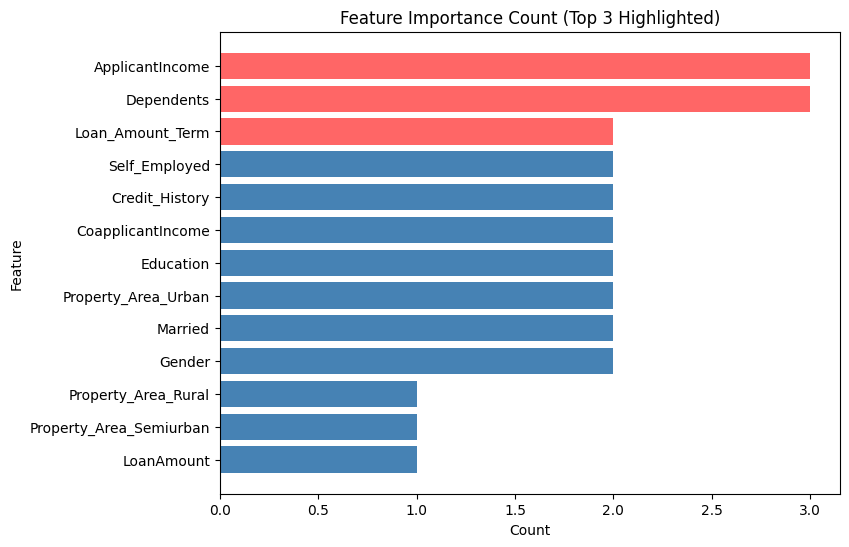

In [152]:
# 統計重要特徵出現的次數
feature_counter = Counter()
for features in important_features_by_variance:
    feature_counter.update(features)

# 將統計結果轉換為 DataFrame 以便繪製橫向長條圖
feature_df = pd.DataFrame(list(feature_counter.items()), columns=['Feature', 'Count'])

# 按照出現次數排序
feature_df = feature_df.sort_values(by='Count', ascending=True)

# 設定顏色，針對前三名特徵進行強調
colors = ['steelblue'] * len(feature_df)
colors[-3:] = ['#ff6666', '#ff6666', '#ff6666']  # 強調前三名特徵

# 繪製橫向長條圖，並使用自定義顏色
plt.figure(figsize=(8, 6))
plt.barh(feature_df['Feature'], feature_df['Count'], color=colors)
plt.xlabel('Count')
plt.ylabel('Feature')
plt.title('Feature Importance Count (Top 3 Highlighted)')
plt.show()
